**Prompt used:**

Problem: Equidistant Vertices in Convex Polygons

Act as an expert in computational geometry and optimization. The problem is related to a conjecture stated as: "Every convex polygon has at least one vertex `v` such that no 4 other vertices are equidistant from `v`."

Your goal is to find a counterexample to this conjecture, or get as close as possible. Specifically, you need to find a convex polygon with `num_vertex` vertices where *every* vertex `v` has (at least) 4 other vertices that are *approximately* equidistant from `v`.

Your task is to implement a search function `search_for_best_polygon(num_vertex)` that takes the desired number of vertices as input and returns a list of 2D coordinates `[(x1, y1), (x2, y2), ..., (x_n, y_n)]` representing the vertices of the best convex polygon found.

Your solution will be evaluated by the `calculate_polygon_score` function, which aims to measure how close the polygon is to satisfying the condition for *all* vertices simultaneously.

You want to maximize this final score. A score close to 1 would indicate a polygon very close to being a counterexample.

You have access to the `calculate_polygon_score(polygon_points, num_vertex)` function within your search code. You don't need to redefine it.

Scoring function you have access to:
```
def calculate_polygon_score(polygon_points: List[Tuple[float, float]], num_vertex: int) -> float:
    """Calculates the overall score for the polygon (minimum vertex score)."""
```

Your search_for_best_polygon function will have 1000 seconds to run. It must return the list of coordinates for the best polygon found within that time.


In [ ]:
#@title First attempt at an evaluation function: enforce a minimum distance between pairs of points

import math
import numpy as np
import time
import random
from typing import Any, Callable, Mapping, List, Tuple, Sequence
import collections
import copy
import numba
from collections import deque
import random
from collections import defaultdict

def is_convex_polygon(polygon: Sequence[Tuple[float, float]]) -> bool:
  """Return True if the polygon defined by the sequence of 2D

  points is 'strictly convex'.

  Checks: points are valid, side lengths non-zero, interior angles
  strictly between 0 and pi, polygon does not intersect itself.
  """
  try:
    if len(polygon) < 3:
      return False

    # Check for duplicate points first
    if len(set(polygon)) != len(polygon):
      return False

    old_x, old_y = polygon[-2]
    new_x, new_y = polygon[-1]
    new_direction = math.atan2(new_y - old_y, new_x - old_x)
    angle_sum = 0.0
    orientation = 0.0  # Undetermined sign of angle changes

    for ndx, newpoint in enumerate(polygon):
      old_x, old_y, old_direction = new_x, new_y, new_direction
      new_x, new_y = newpoint
      new_direction = math.atan2(new_y - old_y, new_x - old_x)

      # Check for zero-length sides
      if old_x == new_x and old_y == new_y:
        return False

      # Calculate & check the normalized direction-change angle
      angle = new_direction - old_direction
      if angle <= -math.pi:
        angle += 2 * math.pi
      elif angle > math.pi:
        angle -= 2 * math.pi

      if angle == 0.0:  # Collinear vertices
        return False

      if ndx == 0:
        orientation = 1.0 if angle > 0.0 else -1.0
      elif orientation * angle <= 0.0:  # Angle change has different sign
        return False

      angle_sum += angle

    # Check that the total number of full turns is plus-or-minus 1
    return abs(round(angle_sum / (2 * math.pi))) == 1
  except (ArithmeticError, TypeError, ValueError, IndexError):
    return False  # Any calculation error implies invalid polygon


def calculate_single_vertex_score(
    vertex_index: int, polygon_points: List[Tuple[float, float]]
) -> float:
  """Calculates the score for a single vertex based on equidistant neighbors."""
  num_vertex = len(polygon_points)
  if num_vertex < 5:  # Need at least 1 vertex + 4 others
    return 0.0

  v = np.array(polygon_points[vertex_index])
  distances = []
  for i, p_tuple in enumerate(polygon_points):
    if i == vertex_index:
      continue
    p = np.array(p_tuple)
    dist = np.linalg.norm(v - p)
    if dist < 5e-2:  # Treat overlapping points as invalid distance
      return 0.0  # Very low score if points overlap v
    distances.append(dist)

  if len(distances) != num_vertex - 1:
    # Should not happen if polygon_points has unique elements
    return -1.0  # Error indicator

  distances.sort()  # Sort distances: d_1, d_2, ..., d_{n-1}
  n_dist = len(distances)  # = num_vertex - 1

  min_gap = float('inf')
  min_gap_idx = -1  # Index k such that gap is between d_k and d_{k+1}

  for k in range(n_dist - 1):
    gap = distances[k + 1] - distances[k]
    if gap < min_gap:
      min_gap = gap
      min_gap_idx = k

  if min_gap_idx == -1:  # Should only happen if n_dist <= 1
    return 0.0  # Not enough points to form a gap

  # Define the target distance Dv
  d_k = distances[min_gap_idx]
  d_k_plus_1 = distances[min_gap_idx + 1]
  D_v = (d_k + d_k_plus_1) / 2.0

  if D_v < 1e-1:  # Avoid division by zero if target distance is tiny
    return 0.0

  # Get the four relevant distances: d_{k-1}, d_k, d_{k+1}, d_{k+2}
  # Handle boundary conditions for indices
  k = min_gap_idx
  indices = []
  if k == 0:  # Gap is between d_0 and d_1. Use d_0, d_1, d_2, d_3
    indices = [0, 1, 2, 3]
  elif (
      k == n_dist - 2
  ):  # Gap is between d_{n-3} and d_{n-2}. Use d_{n-4}, d_{n-3}, d_{n-2}, d_{n-1}
    indices = [n_dist - 4, n_dist - 3, n_dist - 2, n_dist - 1]
  else:  # Standard case: use k-1, k, k+1, k+2
    indices = [k - 1, k, k + 1, k + 2]

  # Ensure indices are valid (can happen if num_vertex is small, e.g., 5)
  valid_indices = [idx for idx in indices if 0 <= idx < n_dist]
  if len(valid_indices) < 4:
    # Not enough points to select 4 distances around the minimum gap
    # This case happens for n=5, where n_dist=4.
    # If k=0, indices=[0,1,2,3]. If k=1(n_dist-3), indices=[0,1,2,3]. If k=2(n_dist-2), indices=[1,2,3]. Needs fixing.
    # Let's redefine: we need *any* 4 points. Let's just take the 4 points centered around the minimum gap index k.
    center_idx = k
    num_needed = 4
    idx_range_start = max(
        0, center_idx - (num_needed // 2) + 1
    )  # Try to center
    idx_range_end = min(n_dist, idx_range_start + num_needed)
    # Adjust start if end hits limit and we don't have enough
    idx_range_start = max(0, idx_range_end - num_needed)

    selected_indices = list(range(idx_range_start, idx_range_end))
    if len(selected_indices) < 4:
      return 0.0  # Still cannot get 4 points (only happens for n<5, already handled)

  else:  # The original indices were valid
    selected_indices = valid_indices

  # Fetch the 4 distances based on selected_indices
  # This part was flawed in the original prompt logic re-interpretation.
  # Let's use the prompt's *intended* indices around minimal gap: d_{k-1}, d_k, d_{k+1}, d_{k+2}
  # And handle boundaries carefully.
  k = min_gap_idx
  try:
    dist_k_minus_1 = distances[selected_indices[0]]
    dist_k = distances[selected_indices[1]]
    dist_k_plus_1 = distances[selected_indices[2]]
    dist_k_plus_2 = distances[selected_indices[3]]
  except IndexError:
    # This can happen if n_dist < 4 (i.e., num_vertex < 5), already handled.
    # Or if indexing logic is still off.
    return 0.0  # Error case

  # Check for zero distances which could cause division issues
  if dist_k_minus_1 < 1e-2 or dist_k < 1e-2:
    # If distances near Dv are zero, something is wrong (overlapping points)
    return 0.0

  # Calculate the raw score as per prompt's formula
  # raw_score_v = (D_v / dist_k_minus_1 + D_v / dist_k + dist_k_plus_1 / D_v + dist_k_plus_2 / D_v) / 4.0
  # Let's measure closeness differently: sum of squared relative errors to D_v
  # error = ((dist_k_minus_1 - D_v)/D_v)**2 + ((dist_k - D_v)/D_v)**2 + ((dist_k_plus_1 - D_v)/D_v)**2 + ((dist_k_plus_2 - D_v)/D_v)**2
  # Score = 1 / (1 + error) # Ranges from 0 to 1, higher is better

  # Using the prompt's formula directly:
  term1 = max(D_v / dist_k_minus_1, dist_k_minus_1 / D_v)
  term2 = max(D_v / dist_k, dist_k / D_v)
  term3 = max(dist_k_plus_1 / D_v, D_v / dist_k_plus_1)
  term4 = max(dist_k_plus_2 / D_v, D_v / dist_k_plus_2)
  raw_score_v = (term1 + term2 + term3 + term4) / 4.0

  # The score should be 1 if raw_score_v is 1 (perfect match) and decrease as it moves away.
  # The prompt suggested score = 1 / raw_score_v. This seems reasonable.
  # raw_score_v should be >= 1 ideally. Let's clamp it slightly above 0.
  if raw_score_v < 1e-2:  # Avoid division by zero/huge scores
    return 0.0

  final_score_v = 1.0 / raw_score_v

  # We want the score to be high when distances ARE equidistant.
  # If d_{k-1}=d_k=d_{k+1}=d_{k+2} = D_v, then raw_score_v = (1+1+1+1)/4 = 1. Score = 1/1 = 1. Perfect.
  # If distances deviate, raw_score_v > 1, so score < 1. This seems correct.

  return max(0.0, min(1.0, final_score_v))  # Ensure score is [0, 1]


def calculate_polygon_score(
    polygon_points: List[Tuple[float, float]], num_vertex: int
) -> float:
  """Calculates the overall score for the polygon (minimum vertex score),

  after centering and normalizing its scale.
  """
  # --- Basic validation ---
  if not isinstance(polygon_points, list):
    return -1_000_000.0
  if len(polygon_points) != num_vertex:
    return -1_000_000.0

  # Use a mutable copy for potential modifications (like scaling)
  current_polygon_points = [
      list(p) for p in polygon_points
  ]  # Convert tuples to lists for potential modification

  # Check for non-float coordinates or NaN/inf in the copy
  for p in current_polygon_points:
    if not isinstance(p, list) or len(p) != 2:
      return -1_000_000.0  # Check list type now
    if not all(isinstance(coord, (int, float)) for coord in p):
      return -1_000_000.0
    p_np = np.array(p, dtype=float)  # Convert to numpy float for isnan/isinf
    if (
        np.isnan(p_np[0])
        or np.isnan(p_np[1])
        or np.isinf(p_np[0])
        or np.isinf(p_np[1])
    ):
      # Try cleaning up NaNs/Infs by clamping or returning penalty
      # For simplicity, let's just penalize heavily.
      # print(f"Warning: NaN/Inf detected in point {p}. Penalizing.")
      return -1_000_000.0

  # Convert to NumPy array for easier calculations
  try:
    coords = np.array(current_polygon_points, dtype=float)
    if coords.shape != (num_vertex, 2):
      return -1_000_000.0  # Shape mismatch after conversion
  except ValueError:
    return -1_000_000.0  # Conversion failed

  # --- Normalization Step ---
  if num_vertex >= 1:
    # 1. Calculate Centroid
    centroid = np.mean(coords, axis=0)

    # 2. Translate to Origin
    coords_centered = coords - centroid

    # 3. Calculate Scale Factor (average distance to origin)
    distances_from_origin = np.linalg.norm(coords_centered, axis=1)
    average_distance = np.mean(distances_from_origin)

    # 4. Rescale (avoid division by zero if all points are coincident)
    if average_distance > 1e-2:
      coords_scaled = coords_centered / average_distance
      # Update the coordinates used for subsequent checks
      # Convert back to list of tuples for compatibility with existing helpers
      scaled_polygon_points_tuples = [tuple(row) for row in coords_scaled]
    else:
      return 0.0
  else:
    # Handle empty polygon case if necessary, though num_vertex check below covers it
    scaled_polygon_points_tuples = []

  # --- Continue with checks using the normalized polygon ---

  # Check convexity using the normalized points
  # Note: is_convex_polygon expects sequence of tuples
  if not is_convex_polygon(scaled_polygon_points_tuples):
    # print("Debug: Polygon failed convexity check after scaling.")
    return -1_000_000.0  # Heavy penalty for non-convex

  # Check minimum vertex requirement
  if num_vertex < 5:
    return 0.0  # Cannot have 4 equidistant points

  # Calculate score for each vertex using the normalized polygon
  vertex_scores = []
  for i in range(num_vertex):
    # Pass the scaled list of tuples to the scoring helper
    score_v = calculate_single_vertex_score(i, scaled_polygon_points_tuples)
    if score_v < 0:  # Check for error indicator from helper
      # print(f"Debug: Error calculating score for vertex {i} after scaling.")
      return -500_000.0  # Penalize errors during calculation
    vertex_scores.append(score_v)

  # Overall score is the minimum score across all vertices
  if not vertex_scores:  # Should not happen if num_vertex >= 5
    return -400_000.0
  min_score = min(vertex_scores)
  # print(vertex_scores) # Keep for debugging if needed

  return min_score


def calculate_polygon_score_hidden(
    polygon_points: List[Tuple[float, float]], num_vertex: int
) -> float:
  """Calculates the overall score for the polygon (minimum vertex score),

  after centering and normalizing its scale.
  """
  # --- Basic validation ---
  if not isinstance(polygon_points, list):
    return -1_000_000.0
  if len(polygon_points) != num_vertex:
    return -1_000_000.0

  # Use a mutable copy for potential modifications (like scaling)
  current_polygon_points = [
      list(p) for p in polygon_points
  ]  # Convert tuples to lists for potential modification

  # Check for non-float coordinates or NaN/inf in the copy
  for p in current_polygon_points:
    if not isinstance(p, list) or len(p) != 2:
      return -1_000_000.0  # Check list type now
    if not all(isinstance(coord, (int, float)) for coord in p):
      return -1_000_000.0
    p_np = np.array(p, dtype=float)  # Convert to numpy float for isnan/isinf
    if (
        np.isnan(p_np[0])
        or np.isnan(p_np[1])
        or np.isinf(p_np[0])
        or np.isinf(p_np[1])
    ):
      # Try cleaning up NaNs/Infs by clamping or returning penalty
      # For simplicity, let's just penalize heavily.
      # print(f"Warning: NaN/Inf detected in point {p}. Penalizing.")
      return -1_000_000.0

  # Convert to NumPy array for easier calculations
  try:
    coords = np.array(current_polygon_points, dtype=float)
    if coords.shape != (num_vertex, 2):
      return -1_000_000.0  # Shape mismatch after conversion
  except ValueError:
    return -1_000_000.0  # Conversion failed

  # --- Normalization Step ---
  if num_vertex >= 1:
    # 1. Calculate Centroid
    centroid = np.mean(coords, axis=0)

    # 2. Translate to Origin
    coords_centered = coords - centroid

    # 3. Calculate Scale Factor (average distance to origin)
    distances_from_origin = np.linalg.norm(coords_centered, axis=1)
    average_distance = np.mean(distances_from_origin)

    # 4. Rescale (avoid division by zero if all points are coincident)
    if average_distance > 1e-3:
      coords_scaled = coords_centered / average_distance
      # Update the coordinates used for subsequent checks
      # Convert back to list of tuples for compatibility with existing helpers
      scaled_polygon_points_tuples = [tuple(row) for row in coords_scaled]
    else:
      return 0.0
  else:
    # Handle empty polygon case if necessary, though num_vertex check below covers it
    scaled_polygon_points_tuples = []

  # --- Continue with checks using the normalized polygon ---

  # Check convexity using the normalized points
  # Note: is_convex_polygon expects sequence of tuples
  if not is_convex_polygon(scaled_polygon_points_tuples):
    # print("Debug: Polygon failed convexity check after scaling.")
    return -1_000_000.0  # Heavy penalty for non-convex

  # Check minimum vertex requirement
  if num_vertex < 5:
    return 0.0  # Cannot have 4 equidistant points

  # Calculate score for each vertex using the normalized polygon
  vertex_scores = []
  for i in range(num_vertex):
    # Pass the scaled list of tuples to the scoring helper
    score_v = calculate_single_vertex_score(i, scaled_polygon_points_tuples)
    if score_v < 0:  # Check for error indicator from helper
      # print(f"Debug: Error calculating score for vertex {i} after scaling.")
      return -500_000.0  # Penalize errors during calculation
    vertex_scores.append(score_v)

  # Overall score is the minimum score across all vertices
  if not vertex_scores:  # Should not happen if num_vertex >= 5
    return -400_000.0
  min_score = min(vertex_scores)
  # print(vertex_scores) # Keep for debugging if needed

  return min_score


def evaluate(params: int) -> tuple[dict[str, float], dict[str, str]]:
  """Evaluates the polygon search for a given number of vertices."""
  result = {}
  feedback = {}
  num_vertex = params

  # Basic check on input parameter
  if not isinstance(num_vertex, int) or num_vertex < 5:
    print(
        f'Warning: num_vertex must be an integer >= 5. Received {num_vertex}.'
        ' Setting score to -inf.'
    )
    result['score'] = -float('inf')
    feedback['error'] = 'num_vertex must be an integer >= 5'
    feedback['best_score_found'] = -float('inf')
    feedback['best_polygon'] = []
    return result, feedback

  best_polygon_points = search_for_best_polygon(num_vertex)
  centroid = np.mean(best_polygon_points, axis=0)

  coords_centered = best_polygon_points - centroid
  distances_from_origin = np.linalg.norm(coords_centered, axis=1)
  average_distance = np.mean(distances_from_origin)

  coords_scaled = coords_centered / average_distance
  scaled_polygon_points_tuples = [tuple(row) for row in coords_scaled]

  best_polygon_points = scaled_polygon_points_tuples

  # Final validation and scoring of the returned polygon
  # Convert to list of tuples if it's numpy array from potential loading
  if isinstance(best_polygon_points, np.ndarray):
    best_polygon_points = [tuple(row) for row in best_polygon_points]
  elif (
      isinstance(best_polygon_points, list)
      and best_polygon_points
      and isinstance(best_polygon_points[0], list)
  ):
    best_polygon_points = [
        tuple(p) for p in best_polygon_points
    ]  # Ensure tuples

  # Recalculate score for safety and final reporting
  score = calculate_polygon_score_hidden(best_polygon_points, num_vertex)

  result['score'] = score
  feedback['best_score_found'] = score
  # Store as list of tuples
  feedback['best_polygon'] = best_polygon_points

  return result, feedback

In [ ]:
#@title Program found by AlphaEvolve

# EVOLVE-BLOCK-START
"""FunSearch experiment codebase for the equidistant vertices in convex polygon problem."""
import time
import numpy as np
import random
from typing import Any, Callable, Mapping, List, Tuple, Sequence
import collections
import copy
import math
import numba
from collections import deque
import random
from collections import defaultdict

def is_convex_polygon_quick(points: np.ndarray) -> bool:
    """Quick convexity check using angles."""
    num_points = len(points)
    if num_points < 3:
        return True  # A point or line is considered convex

    # Calculate angles and check for consistent turning direction
    is_clockwise = None
    for i in range(num_points):
        p1 = points[i]
        p2 = points[(i + 1) % num_points]
        p3 = points[(i + 2) % num_points]

        cross_product = (p2[0] - p1[0]) * (p3[1] - p2[1]) - (p2[1] - p1[1]) * (p3[0] - p2[0])

        if is_clockwise is None:
            is_clockwise = cross_product > 0
        elif (cross_product > 0) != is_clockwise:
            return False  # Inconsistent turning direction

    return True
import collections
import copy
import math
import numba
import scipy
from scipy.spatial import Delaunay, ConvexHull
from collections import deque

def is_convex_polygon_quick(points: np.ndarray) -> bool:
    """Quick convexity check using angles."""
    num_points = len(points)
    if num_points < 3:
        return True  # A point or line is considered convex

    # Calculate angles and check for consistent turning direction
    is_clockwise = None
    for i in range(num_points):
        p1 = points[i]
        p2 = points[(i + 1) % num_points]
        p3 = points[(i + 2) % num_points]

        cross_product = (p2[0] - p1[0]) * (p3[1] - p2[1]) - (p2[1] - p1[1]) * (p3[0] - p2[0])

        if is_clockwise is None:
            is_clockwise = cross_product > 0
        elif (cross_product > 0) != is_clockwise:
            return False  # Inconsistent turning direction

    return True


def get_rounded_rectangle_points(num_points: int, width: float, height: float, corner_radius: float) -> np.ndarray:
    """
    Generates points for a rounded rectangle.

    Args:
        num_points: The number of points to generate.
        width: The width of the rectangle.
        height: The height of the rectangle.
        corner_radius: The radius of the rounded corners.

    Returns:
        A numpy array of shape (num_points, 2) containing the points.
    """
    if corner_radius > min(width / 2, height / 2):
        corner_radius = min(width / 2, height / 2)

    # Calculate the length of each segment (sides and arcs)
    side_length_w = width - 2 * corner_radius
    side_length_h = height - 2 * corner_radius
    arc_length = np.pi / 2 * corner_radius

    total_length = 2 * (side_length_w + side_length_h + 2 * arc_length)

    # Calculate the number of points for each segment
    num_points_side_w = max(1, round(num_points * side_length_w / total_length))
    num_points_side_h = max(1, round(num_points * side_length_h / total_length))
    num_points_arc = max(1, round(num_points * arc_length / total_length))

    # Ensure we have enough points
    remaining_points = num_points - 2 * (num_points_side_w + num_points_side_h + num_points_arc)
    if remaining_points > 0:
        num_points_side_w += remaining_points // 4
        num_points_side_h += remaining_points // 4
        num_points_arc += remaining_points // 4

    num_points_side_w = max(1, num_points_side_w)
    num_points_side_h = max(1, num_points_side_h)
    num_points_arc = max(1, num_points_arc)

    # Generate points for each segment
    points = []

    # Bottom side
    points.extend([(corner_radius + i * side_length_w / num_points_side_w, -height / 2) for i in range(num_points_side_w)])
    # Bottom-right arc
    points.extend([(width / 2 - corner_radius * np.cos(np.linspace(0, np.pi/2, num_points_arc)), -height / 2 + corner_radius * np.sin(np.linspace(0, np.pi/2, num_points_arc))) for i in range(num_points_arc)])
    # Right side
    points.extend([(width / 2, -corner_radius + i * side_length_h / num_points_side_h) for i in range(num_points_side_h)])
    # Top-right arc
    points.extend([(width / 2 - corner_radius * np.sin(np.linspace(0, np.pi/2, num_points_arc)), corner_radius + height / 2 - corner_radius * np.cos(np.linspace(0, np.pi/2, num_points_arc))) for i in range(num_points_arc)])
    # Top side
    points.extend([(width / 2 - corner_radius - i * side_length_w / num_points_side_w, height / 2) for i in range(num_points_side_w)])
    # Top-left arc
    points.extend([(-width / 2 + corner_radius * np.cos(np.linspace(0, np.pi/2, num_points_arc)), corner_radius + height / 2 - corner_radius * np.sin(np.linspace(0, np.pi/2, num_points_arc))) for i in range(num_points_arc)])
    # Left side
    points.extend([(-width / 2, height / 2 - corner_radius - i * side_length_h / num_points_side_h) for i in range(num_points_side_h)])
    # Bottom-left arc
    points.extend([(-width / 2 + corner_radius * np.sin(np.linspace(0, np.pi/2, num_points_arc)), -height / 2 + corner_radius * np.cos(np.linspace(0, np.pi/2, num_points_arc))) for i in range(num_points_arc)])

    # Convert to numpy array
    points = np.array(points)

    # Normalize to have num_points.  Remove points
    while len(points) > num_points:
        remove_index = np.random.randint(0, len(points))
        points = np.delete(points, remove_index, axis=0)

    # Add points to fill in any that are missing
    while len(points) < num_points:
        add_index = np.random.randint(0, len(points))
        points = np.vstack([points, points[add_index, :]])

    # Shuffle Points for good measure
    np.random.shuffle(points)
    return points[:num_points]

# EVOLVE-BLOCK-END

# PREVIOUS CONSTRUCTIONS START HERE


best_score_found_20 = np.float64(0.9994822977347143)
best_polygon_20 = [(np.float64(1.2497221832592478), np.float64(-0.534324890712548)), (np.float64(-0.33433479409989514), np.float64(0.3315670570563435)), (np.float64(-0.3782078922745673), np.float64(0.3555493777008542)), (np.float64(-0.4223403192832722), np.float64(0.3796734550714596)), (np.float64(-1.1317990898770884), np.float64(0.7674844004656376)), (np.float64(-1.1613654348920406), np.float64(0.725957070252956)), (np.float64(-1.1876538111969963), np.float64(0.6833473357529398)), (np.float64(-1.210822561288201), np.float64(0.6390392211551309)), (np.float64(-1.2312937308851966), np.float64(0.5923480830397957)), (np.float64(-0.5769761661299708), np.float64(0.21931869002041066)), (np.float64(-0.4768609874173963), np.float64(0.1622425753735107)), (np.float64(-0.4334240765161207), np.float64(0.13747899669537042)), (np.float64(-0.049924062472224404), np.float64(-0.08115608930041183)), (np.float64(0.6948834456175214), np.float64(-0.5057742056183557)), (np.float64(0.7383203560604911), np.float64(-0.5305377839394385)), (np.float64(1.1277886521837863), np.float64(-0.7525754139883994)), (np.float64(1.1579649653546213), np.float64(-0.7121161513405342)), (np.float64(1.1854134507771446), np.float64(-0.6701989712129289)), (np.float64(1.2098456902384314), np.float64(-0.6265748302389446)), (np.float64(1.2310641828417268), np.float64(-0.5807479262328467))]
best_score_found_25 = np.float64(0.9539801852763198)
best_polygon_25 = [(np.float64(-0.7821201200835133), np.float64(0.6352928665394019)), (np.float64(-0.9249211872604476), np.float64(0.36880596193434484)), (np.float64(-0.9977905950613477), np.float64(0.06665297294382785)), (np.float64(-0.9988084929158614), np.float64(-0.07602396156107993)), (np.float64(-0.9226702609962879), np.float64(-0.35953845893390285)), (np.float64(-0.8160417074144245), np.float64(-0.600028248063212)), (np.float64(-0.6191099724187241), np.float64(-0.7602647477182881)), (np.float64(-0.44344072238213794), np.float64(-0.9031990335898482)), (np.float64(-0.199825774192101), np.float64(-0.9750004818642457)), (np.float64(0.033543327431278726), np.float64(-1.0034239819253679)), (np.float64(0.33061080879753946), np.float64(-0.9506212268287962)), (np.float64(0.5370968368948883), np.float64(-0.8263156269337628)), (np.float64(0.7135590698671999), np.float64(-0.6855542284392554)), (np.float64(0.8907527814678586), np.float64(-0.4890782466238807)), (np.float64(0.9805613942002999), np.float64(-0.25351024473302186)), (np.float64(0.9986164299763856), np.float64(-0.013868367588572246)), (np.float64(0.9752364078845019), np.float64(0.2551117416388076)), (np.float64(0.9001799496134822), np.float64(0.5059430472341897)), (np.float64(0.7334652178129866), np.float64(0.6936318603565206)), (np.float64(0.5345599934500548), np.float64(0.8335836506745888)), (np.float64(0.2984884536722679), np.float64(0.9545468638154693)), (np.float64(0.05982475918383195), np.float64(0.981997994892249)), (np.float64(-0.19486780148613878), np.float64(0.9857747436792588)), (np.float64(-0.4278955225570084), np.float64(0.8905966653731628)), (np.float64(-0.6590032734845841), np.float64(0.7244884857214137))]
best_score_found_30 = np.float64(0.9455350422254342)
best_polygon_30 = [(np.float64(-0.9665332675969462), np.float64(-0.1895676853317045)), (np.float64(-0.9248676654164991), np.float64(-0.4129003117732286)), (np.float64(-0.8006127211676712), np.float64(-0.5767042601429551)), (np.float64(-0.6734586751253308), np.float64(-0.744329847895534)), (np.float64(-0.5074617723313277), np.float64(-0.8647024642923222)), (np.float64(-0.3105540709656901), np.float64(-0.943613633813824)), (np.float64(-0.11106692002684228), np.float64(-1.0016358259246168)), (np.float64(0.0953184803342949), np.float64(-0.9931143818008669)), (np.float64(0.30043520504322324), np.float64(-0.9586508079339213)), (np.float64(0.519758844817402), np.float64(-0.8534257383866493)), (np.float64(0.6618410877023584), np.float64(-0.7358719789387852)), (np.float64(0.7964637806526927), np.float64(-0.6165627068872482)), (np.float64(0.9141894922512489), np.float64(-0.4146635223064962)), (np.float64(0.9854968049240517), np.float64(-0.20806560471249394)), (np.float64(1.0068409563675793), np.float64(0.0012659640350479566)), (np.float64(0.9775425034394328), np.float64(0.1992507671175948)), (np.float64(0.9157505677248541), np.float64(0.4062248722268378)), (np.float64(0.8170254920555916), np.float64(0.6273032149125402)), (np.float64(0.6625478373493325), np.float64(0.7396170647482092)), (np.float64(0.5202825734712228), np.float64(0.8255858445111349)), (np.float64(0.30211246245231527), np.float64(0.9574227926914729)), (np.float64(0.09908206200291318), np.float64(0.9898591108093824)), (np.float64(-0.11353123592410161), np.float64(0.9921208984298346)), (np.float64(-0.32277087164563173), np.float64(0.948066451807925)), (np.float64(-0.4997313796145226), np.float64(0.8771579838274666)), (np.float64(-0.6601968452877143), np.float64(0.7524750750304424)), (np.float64(-0.8110063403227402), np.float64(0.5853657707857938)), (np.float64(-0.9122134428784566), np.float64(0.41970068671242494)), (np.float64(-0.9841457709016862), np.float64(0.19311639875008516)), (np.float64(-0.976537171383352), np.float64(-0.000724126255548632))]
best_score_found_35 = np.float64(0.993592718731406)
best_polygon_35 = [(np.float64(0.26301914253306397), np.float64(0.9493651727741393)), (np.float64(-0.09780326461607838), np.float64(0.9974985184709652)), (np.float64(-0.22770771475877813), np.float64(0.9690042727943314)), (np.float64(-0.4611472802447572), np.float64(0.8857954072763228)), (np.float64(-0.5549266738358507), np.float64(0.8310588775161732)), (np.float64(-0.6091887624960499), np.float64(0.7903008763901439)), (np.float64(-0.8742039556482011), np.float64(0.4931145371271882)), (np.float64(-0.9026750497295698), np.float64(0.4304646324422677)), (np.float64(-0.9914477475592743), np.float64(0.15974972997524922)), (np.float64(-0.997175783949553), np.float64(0.09199824708509353)), (np.float64(-1.0069898975751093), np.float64(-0.02408619359755175)), (np.float64(-0.9620839360069552), np.float64(-0.3024527428528275)), (np.float64(-0.903845245785163), np.float64(-0.4606654821805127)), (np.float64(-0.8568763863957396), np.float64(-0.5817679523497484)), (np.float64(-0.6478522431614714), np.float64(-0.7792260739595445)), (np.float64(-0.5823956110933339), np.float64(-0.8275763296663011)), (np.float64(-0.411855134615662), np.float64(-0.9147210135386127)), (np.float64(-0.23131800650283946), np.float64(-0.960778914415471)), (np.float64(-0.027890300880579148), np.float64(-0.9823467783786612)), (np.float64(0.05266389604814932), np.float64(-0.98361485326994)), (np.float64(0.30337295819158583), np.float64(-0.9231374166837187)), (np.float64(0.5784171695534339), np.float64(-0.824473901498175)), (np.float64(0.615000523081223), np.float64(-0.7797505055218731)), (np.float64(0.717185512326098), np.float64(-0.6548286660051713)), (np.float64(0.8512274969474916), np.float64(-0.4909614344758641)), (np.float64(0.8732493545417078), np.float64(-0.4460720628615744)), (np.float64(1.047962752428682), np.float64(-0.08993466677769214)), (np.float64(1.0135680654816328), np.float64(0.12641120149946644)), (np.float64(0.9928116339133526), np.float64(0.20304950607452327)), (np.float64(0.9425444097745825), np.float64(0.37100359333572797)), (np.float64(0.8273848460955037), np.float64(0.5374402724277982)), (np.float64(0.7477991404669253), np.float64(0.6524630950288072)), (np.float64(0.63471365806359), np.float64(0.778112177823581)), (np.float64(0.4864933124217266), np.float64(0.8613563031332879)), (np.float64(0.3999691229862207), np.float64(0.8982085668581731))]
best_score_found_40 = np.float64(0.9837286774043347)
best_polygon_40 = [(np.float64(-0.734134990999881), np.float64(-0.6970435443106446)), (np.float64(-0.6347398332528819), np.float64(-0.7792254571403944)), (np.float64(-0.44574741440500354), np.float64(-0.8845230322073534)), (np.float64(-0.30793525043909004), np.float64(-0.950916393617282)), (np.float64(-0.20336094089614845), np.float64(-0.9999264558590295)), (np.float64(-0.0001433738667123009), np.float64(-0.9993106500745594)), (np.float64(0.1566787379602864), np.float64(-0.9864741945497859)), (np.float64(0.3086515477950585), np.float64(-0.9512575575034213)), (np.float64(0.453465843194112), np.float64(-0.890041116531126)), (np.float64(0.5869728185649137), np.float64(-0.8077906735269341)), (np.float64(0.7196493469900425), np.float64(-0.7260518489323756)), (np.float64(0.8065060072502457), np.float64(-0.5882624022237501)), (np.float64(0.880517051481199), np.float64(-0.4486775528938782)), (np.float64(0.9494367458278645), np.float64(-0.3093294160759786)), (np.float64(0.9858784326820226), np.float64(-0.1577858879158684)), (np.float64(0.9911187002452538), np.float64(0.004895336250041973)), (np.float64(0.9847103261756818), np.float64(0.1552280268513763)), (np.float64(0.9661154099805639), np.float64(0.3229770495773085)), (np.float64(0.9062443157920466), np.float64(0.4316323928931939)), (np.float64(0.8076723497231035), np.float64(0.5859607818381517)), (np.float64(0.778007386860585), np.float64(0.626210289511933)), (np.float64(0.5462054020182695), np.float64(0.8480393008374447)), (np.float64(0.4532356137903773), np.float64(0.8880669235563516)), (np.float64(0.3047393682141778), np.float64(0.9486038543125029)), (np.float64(0.15670584829483827), np.float64(0.9846572419200046)), (np.float64(0.00016626964719560213), np.float64(0.9969196830729367)), (np.float64(-0.13146159303756327), np.float64(0.9853710782989102)), (np.float64(-0.3088062155825461), np.float64(0.9483752208303411)), (np.float64(-0.4430187293084049), np.float64(0.894517896464342)), (np.float64(-0.5871321923452165), np.float64(0.8061219381890118)), (np.float64(-0.7046623917831918), np.float64(0.7051338320667155)), (np.float64(-0.8075480862680467), np.float64(0.5854949372718649)), (np.float64(-0.8654552661339402), np.float64(0.49126434626774257)), (np.float64(-0.9498724713470825), np.float64(0.30704625914113576)), (np.float64(-0.9880485673326871), np.float64(0.15743522416563713)), (np.float64(-1.0020329732476914), np.float64(0.01023907679781599)), (np.float64(-0.9849983247024365), np.float64(-0.1570090024975054)), (np.float64(-0.9496187100174512), np.float64(-0.31064858402960027)), (np.float64(-0.8869604014566682), np.float64(-0.45305728884586693)), (np.float64(-0.8069997960651965), np.float64(-0.5868596313794099))]
best_score_found_45 = np.float64(0.9948639960189571)
best_polygon_45 = [(np.float64(-0.9993147231826756), np.float64(-0.008070468223418087)), (np.float64(-0.9982006820400539), np.float64(-0.06859469779062534)), (np.float64(-0.9762894035410846), np.float64(-0.20714303657688873)), (np.float64(-0.9591267356312173), np.float64(-0.31447671287942075)), (np.float64(-0.9225480065524434), np.float64(-0.401774586895485)), (np.float64(-0.8092297115974756), np.float64(-0.5902528824445322)), (np.float64(-0.7141260586740658), np.float64(-0.6990624346003723)), (np.float64(-0.6503736428600327), np.float64(-0.7574869563827539)), (np.float64(-0.4959731237173503), np.float64(-0.8609828777939023)), (np.float64(-0.3554973171514012), np.float64(-0.9323349855973825)), (np.float64(-0.28188556450271474), np.float64(-0.9474741738396792)), (np.float64(-0.06021414570639256), np.float64(-0.9909292692953816)), (np.float64(0.058381103934419115), np.float64(-1.0102535421107477)), (np.float64(0.1731615769830754), np.float64(-0.9835581888598954)), (np.float64(0.29699295100300865), np.float64(-0.9474818138739673)), (np.float64(0.4389952226616304), np.float64(-0.8972916618067603)), (np.float64(0.5588304126020697), np.float64(-0.8279026558013416)), (np.float64(0.6707006053973132), np.float64(-0.7494761596592987)), (np.float64(0.7102963619017093), np.float64(-0.7035439949050715)), (np.float64(0.8343904831173105), np.float64(-0.5432207697364306)), (np.float64(0.86194712303204), np.float64(-0.4950428824933996)), (np.float64(0.9645691292310616), np.float64(-0.29862119921623503)), (np.float64(0.9894581504211918), np.float64(-0.13542064662470665)), (np.float64(1.0035524871895614), np.float64(-0.004751384962641388)), (np.float64(0.9902572624251041), np.float64(0.14340803267882188)), (np.float64(0.9435497690198347), np.float64(0.33864531777148704)), (np.float64(0.9027527425771603), np.float64(0.420852300667401)), (np.float64(0.8472250381021358), np.float64(0.5320486849056093)), (np.float64(0.7931169598509937), np.float64(0.6266930435937557)), (np.float64(0.6681042821570148), np.float64(0.7437435284006018)), (np.float64(0.5470026137765597), np.float64(0.8313836724457931)), (np.float64(0.48426823449945716), np.float64(0.8643447772102482)), (np.float64(0.30661048293827303), np.float64(0.9509893038926419)), (np.float64(0.17933819843997004), np.float64(0.9845192473972431)), (np.float64(0.060038716586808934), np.float64(0.9940810457574524)), (np.float64(-0.12668246320480928), np.float64(0.9932653147954301)), (np.float64(-0.24575149141281746), np.float64(0.9704241460069156)), (np.float64(-0.3731728771823078), np.float64(0.9264655556504603)), (np.float64(-0.4613701400775829), np.float64(0.8888977447812079)), (np.float64(-0.5800889321791236), np.float64(0.8255242899124317)), (np.float64(-0.6740677797175104), np.float64(0.7278238582667645)), (np.float64(-0.8098851724532036), np.float64(0.5859544408137645)), (np.float64(-0.8593398869627529), np.float64(0.5249285984883567)), (np.float64(-0.9401560889092206), np.float64(0.3443838396951829)), (np.float64(-0.9902459605914672), np.float64(0.15677123923876915))]


# PREVIOUS CONSTRUCTIONS END HERE


# EVOLVE-BLOCK-START
def search_for_best_polygon(num_vertex: int) -> List[Tuple[float, float]]:
  """Searches for the best convex polygon maximizing the minimum vertex score."""
  variable_name = f'best_polygon_{num_vertex}'
  archive_size = 5 # Number of historical polygons to keep
  polygon_archive = deque(maxlen=archive_size)

  if variable_name in globals():
    polygon_points = [tuple(p) for p in globals()[variable_name]]
    if not is_convex_polygon(polygon_points) or len(polygon_points) != num_vertex:
      print(f'Loaded polygon invalid for {num_vertex}, re-initializing.')
      polygon_points = None
    else:
      print(f'Loaded GLOBAL best polygon for {num_vertex}')
  else:
    polygon_points = None

  best_score = -1.0

  if polygon_points is None:
    # Initialize on a circle
    radius = 3.0 * (1.0 + 15.0 / num_vertex)
    angles = np.linspace(0, 2 * np.pi, num_vertex, endpoint=False)
    initial_jitter = 0.01 * radius  # Add a small random jitter
    polygon_points = [(radius * np.cos(a) + np.random.uniform(-initial_jitter, initial_jitter),
                       radius * np.sin(a) + np.random.uniform(-initial_jitter, initial_jitter)) for a in angles]

  mutation_start_time = time.time()
  best_score = -1.0
  mutation_eval_count = 0

  best_polygon_points = copy.deepcopy(polygon_points)
  best_score = calculate_polygon_score(best_polygon_points, num_vertex)
  print(f'Initial score for {num_vertex} vertices: {best_score:.6f}')
  last_improvement_time = time.time()

  while time.time() - mutation_start_time < 900 and time.time() - last_improvement_time < 150:
    # Historical Mutation
    if np.random.rand() < 0.05:
      current_polygon = np.array(copy.deepcopy(best_polygon_points))
    else:
        current_polygon = np.array(copy.deepcopy(best_polygon_points))  # Convert to NumPy array once

    time_factor = 1.0 - (time.time() - mutation_start_time) / 900
    step_scale = 0.0005 * (1.0 - best_score) * time_factor / (num_vertex / 20.0)

    temperature = (1.0 - best_score)   # Simulated annealing temperature

    # Mutation Type Selection
    mutation_type = np.random.choice(["multi_center", "radial_or_centroid", "triangulation"], p=[0.75, 0.15, 0.10])

    if mutation_type == "multi_center":
        center_idx = np.random.randint(0, num_vertex)
        num_to_nudge = max(1, int(num_vertex * (0.1 + 0.1 * (1.0 - best_score))))

        #Adaptive Target Selection
        other_indices = [i for i in range(num_vertex) if i != center_idx]
        distances_to_center = np.sqrt(np.sum((current_polygon[other_indices] - current_polygon[center_idx])**2, axis=1))
        weights = np.exp(-distances_to_center / np.mean(distances_to_center))
        weights /= np.sum(weights)

        target_indices = np.random.choice(other_indices, size=num_to_nudge, replace=False, p=weights)

        if target_indices.size > 0:
            # Vectorized distance and direction calculation BEFORE the center is moved.
            diffs_initial = current_polygon[target_indices] - current_polygon[center_idx]
            distances_initial = np.linalg.norm(diffs_initial, axis=1)
            mean_distance_initial = np.mean(distances_initial)

        # Nudge the center point towards the average of the target points.
        center_nudge_factor = step_scale * 0.01 # Even smaller step for multi-center
        center_adjustment = np.mean(current_polygon[target_indices], axis=0) - current_polygon[center_idx]
        # Introduce a small probability of moving the center *away* from the average
        if np.random.rand() < 0.1:
            current_polygon[center_idx] -= (1.0 - best_score) * center_nudge_factor * center_adjustment
        else:
            current_polygon[center_idx] += center_nudge_factor * center_adjustment

        # Recalculate after moving the center.
        diffs = current_polygon[target_indices] - current_polygon[center_idx]
        distances = np.linalg.norm(diffs, axis=1)
        mean_distance = np.mean(distances)
        directions = diffs / (np.linalg.norm(diffs, axis=1, keepdims=True) + 1e-6)

        # Combined adjustment and in-place modification
        adjustments = step_scale * (mean_distance - distances) * np.random.normal(0, 0.15 * (1.0 - best_score) * (25.0 / num_vertex), size=len(target_indices))
        current_polygon[target_indices] += adjustments[:, np.newaxis] * directions

    elif mutation_type == "radial_or_centroid":
      idx_to_mutate = np.random.randint(0, num_vertex)

      if np.random.rand() < 0.5:
        # Apply radial perturbation to a single random vertex
        x, y = current_polygon[idx_to_mutate]
        radius = np.sqrt(x**2 + y**2)
        angle = np.arctan2(y, x)
        new_radius = radius + np.random.normal(0, step_scale * radius * 0.5)  # Adjust radius
        new_angle = angle + np.random.normal(0, step_scale * 0.2) # Adjust angle
        current_polygon[idx_to_mutate] = (new_radius * np.cos(new_angle), new_radius * np.sin(new_angle))
      else:
        # Calculate the centroid of the polygon
        centroid_x = np.mean(current_polygon[:, 0])
        centroid_y = np.mean(current_polygon[:, 1])

        # Apply radial and angular perturbation relative to the centroid
        x, y = current_polygon[idx_to_mutate]
        dx = x - centroid_x
        dy = y - centroid_y
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)

        # Perturb radius and angle (similar to 'radial', but from centroid)
        new_radius = radius + np.random.normal(0, step_scale * radius * 0.5)
        angle_scale = 0.1
        new_angle = angle + np.random.normal(0, step_scale * angle_scale)

        new_x = centroid_x + new_radius * np.cos(new_angle)
        new_y = centroid_y + new_radius * np.sin(new_angle)
        current_polygon[idx_to_mutate] = (new_x, new_y)

    elif mutation_type == "triangulation":
        try:
            tri = Delaunay(current_polygon)
            num_triangles = tri.simplices.shape[0]

            # --- Targeted Triangulation ---
            jitter_scale = step_scale * temperature * 0.1

            triangle_aspect_ratios = []
            for triangle_indices in tri.simplices:
                triangle_points = current_polygon[triangle_indices]
                # Calculate side lengths
                a = np.linalg.norm(triangle_points[0] - triangle_points[1])
                b = np.linalg.norm(triangle_points[1] - triangle_points[2])
                c = np.linalg.norm(triangle_points[2] - triangle_points[0])
                # Calculate semi-perimeter and area
                s = (a + b + c) / 2
                area = np.sqrt(s * (s - a) * (s - b) * (s - c))
                # Calculate aspect ratio (inradius/circumradius ratio)
                if area > 1e-6: #Avoid zero-division
                    aspect_ratio = (4 * area) / (a+b+c)  / (a*b*c / (4 * area)) #Smaller means thinner
                    triangle_aspect_ratios.append((aspect_ratio, triangle_indices))
                else:
                    triangle_aspect_ratios.append((1.0, triangle_indices))

            triangle_aspect_ratios.sort() #Sort by aspect ratio, smallest first.

            # Perturb only the vertices of the worst 20% of triangles
            num_to_perturb = max(1, int(0.2 * num_triangles))
            for _, triangle_indices in triangle_aspect_ratios[:num_to_perturb]:
                for vertex_idx in triangle_indices:
                  current_polygon[vertex_idx] += np.random.normal(0, jitter_scale, size=2)

            # Reconstruct the polygon using Convex Hull
            hull = ConvexHull(current_polygon)
            current_polygon = current_polygon[hull.vertices]

            # Handle the edge case where the convex hull reduces the number of vertices
            if len(current_polygon) < num_vertex:
                # Add random points to fill in the missing vertices
                num_missing = num_vertex - len(current_polygon)
                min_x = np.min(current_polygon[:, 0])
                max_x = np.max(current_polygon[:, 0])
                min_y = np.min(current_polygon[:, 1])
                max_y = np.max(current_polygon[:, 1])
                new_points = np.random.uniform([min_x, min_y], [max_x, max_y], size=(num_missing, 2))
                current_polygon = np.vstack([current_polygon, new_points])
            elif len(current_polygon) > num_vertex:
                 #Remove points if too many.
                indices_to_remove = np.random.choice(len(current_polygon), size=len(current_polygon) - num_vertex, replace=False)
                current_polygon = np.delete(current_polygon, indices_to_remove, axis=0)

            #Ensure that it has the correct size.
            current_polygon = current_polygon[:num_vertex]


        except scipy.spatial.qhull. QhullError:
            # Handle potential Qhull errors (e.g., coplanar points)
            print("QhullError encountered. Skipping triangulation mutation.")
            continue  # Skip to the next iteration


    if not is_convex_polygon_quick(current_polygon):
        continue #reject if not convex

    score = calculate_polygon_score(current_polygon.tolist(), num_vertex) # convert back to list of tuples
    mutation_eval_count += 1

    if score > best_score:
      best_score = score
      best_polygon_points = copy.deepcopy(current_polygon)
      last_improvement_time = time.time()
      print(f'Mutation found new best score: {best_score:.6f} (evals: {mutation_eval_count})')
  print(f'Final score after mutation: {best_score:.6f}')
  return best_polygon_points


# EVOLVE-BLOCK-END



In [ ]:
#@title Visualization code

import matplotlib.pyplot as plt
import matplotlib.cm as cm # For colormaps
from typing import Any, Callable, Mapping, List, Tuple, Sequence



def plot_polygon_equidistance(polygon_points: List[Tuple[float, float]],
                               tolerance: float = 0.01, # Relative tolerance for distance match
                               filename: str = "polygon_visualization.png"):
    """
    Plots the polygon and highlights pairs (v, p) where dist(v, p) is
    close to the target distance D_v calculated for vertex v.

    Args:
        polygon_points: List of (x, y) tuples for the polygon vertices.
        tolerance: Relative tolerance (e.g., 0.05 means within 5%) to
                   consider a distance equal to the target distance D_v.
        filename: Path to save the plot image. If None, displays the plot.
    """
    num_vertex = len(polygon_points)
    if num_vertex < 5:
        print(f"Plotting skipped: Need at least 5 vertices, have {num_vertex}.")
        return
    if not is_convex_polygon(polygon_points):
         print("Warning: Plotting a non-convex polygon.")
         # We can still plot it, but the interpretation might be odd.

    coords = np.array(polygon_points)
    x_coords, y_coords = coords[:, 0], coords[:, 1]

    plt.figure(figsize=(10, 10))

    # 1. Plot the polygon edges
    plt.plot(np.append(x_coords, x_coords[0]), np.append(y_coords, y_coords[0]),
             'k-', linewidth=1.5, label='Polygon Edges')

    # 2. Plot the vertices
    plt.plot(x_coords, y_coords, 'ko', markersize=5, label='Vertices')
    # Optional: Label vertices
    # for i, (x, y) in enumerate(coords):
    #     plt.text(x + 0.01 * (max(x_coords)-min(x_coords)), y, str(i), fontsize=8)


    # 3. Highlight equidistant pairs
    # Use a colormap for different originating vertices
    colors = cm.get_cmap('turbo', num_vertex) # 'tab10', 'tab20', 'viridis', 'turbo' are good options

    highlight_count = 0
    for i in range(num_vertex): # For each vertex v (index i)
        v = coords[i]
        v_color = colors(i / (num_vertex -1)) if num_vertex > 1 else colors(0.5) # Get color for this vertex

        # Calculate distances from v to all other points
        distances_from_v = []
        original_indices = [] # Keep track of original index for each distance
        for j in range(num_vertex):
            if i == j: continue
            p = coords[j]
            dist = np.linalg.norm(v - p)
            if dist < 1e-9: continue # Skip zero distances
            distances_from_v.append(dist)
            original_indices.append(j)

        if len(distances_from_v) < num_vertex - 1: continue # Should not happen normally

        # Sort distances and find the minimum gap index (k)
        sorted_indices = np.argsort(distances_from_v)
        sorted_distances = np.array(distances_from_v)[sorted_indices]
        n_dist = len(sorted_distances) # = num_vertex - 1

        if n_dist < 2: continue # Need at least two distances to find a gap

        min_gap = float('inf')
        min_gap_idx = -1 # Index k such that gap is between sorted_distances[k] and sorted_distances[k+1]
        for k in range(n_dist - 1):
            gap = sorted_distances[k+1] - sorted_distances[k]
            if gap < min_gap:
                min_gap = gap
                min_gap_idx = k

        if min_gap_idx == -1: continue # Should not happen if n_dist >= 2

        # Calculate the target distance D_v
        d_k = sorted_distances[min_gap_idx]
        d_k_plus_1 = sorted_distances[min_gap_idx + 1]
        D_v = (d_k + d_k_plus_1) / 2.0

        if D_v < 1e-9: continue # Avoid division by zero

        # Now check all other points p (index j)
        for j in range(num_vertex):
            if i == j: continue
            p = coords[j]
            dist_vp = np.linalg.norm(v - p)

            # Check if dist_vp is close to D_v within the tolerance
            if abs(dist_vp - D_v) <= tolerance * D_v:
                # Plot a line segment from v to p with the specific color
                plt.plot([v[0], p[0]], [v[1], p[1]], color=v_color, linestyle='--', linewidth=1.0, alpha=0.7)
                highlight_count += 1


    # Final plot adjustments
    plt.title(f"Polygon Equidistance Visualization ({num_vertex} vertices)\nHighlighted segments show dist(v, p) ≈ D_v (tol={tolerance*100:.1f}%)")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.gca().set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
    # Add padding around the polygon
    x_range = max(x_coords) - min(x_coords)
    y_range = max(y_coords) - min(y_coords)
    padding = max(x_range, y_range) * 0.1 # 10% padding
    plt.xlim(min(x_coords) - padding, max(x_coords) + padding)
    plt.ylim(min(y_coords) - padding, max(y_coords) + padding)
    plt.grid(True, linestyle=':', alpha=0.5)

    # Add a legend entry for the highlighted lines (difficult due to multiple colors)
    # Instead, mention in title or use a dummy line
    if highlight_count > 0:
        plt.plot([], [], linestyle='--', color='gray', label=f'dist(v, p) ≈ D_v (by vertex v color)') # Dummy entry
        plt.legend(fontsize=8)
    else:
         plt.legend(fontsize=8)



    plt.show()

/tmp/ipython-input-2-1517633699.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('turbo', num_vertex) # 'tab10', 'tab20', 'viridis', 'turbo' are good options


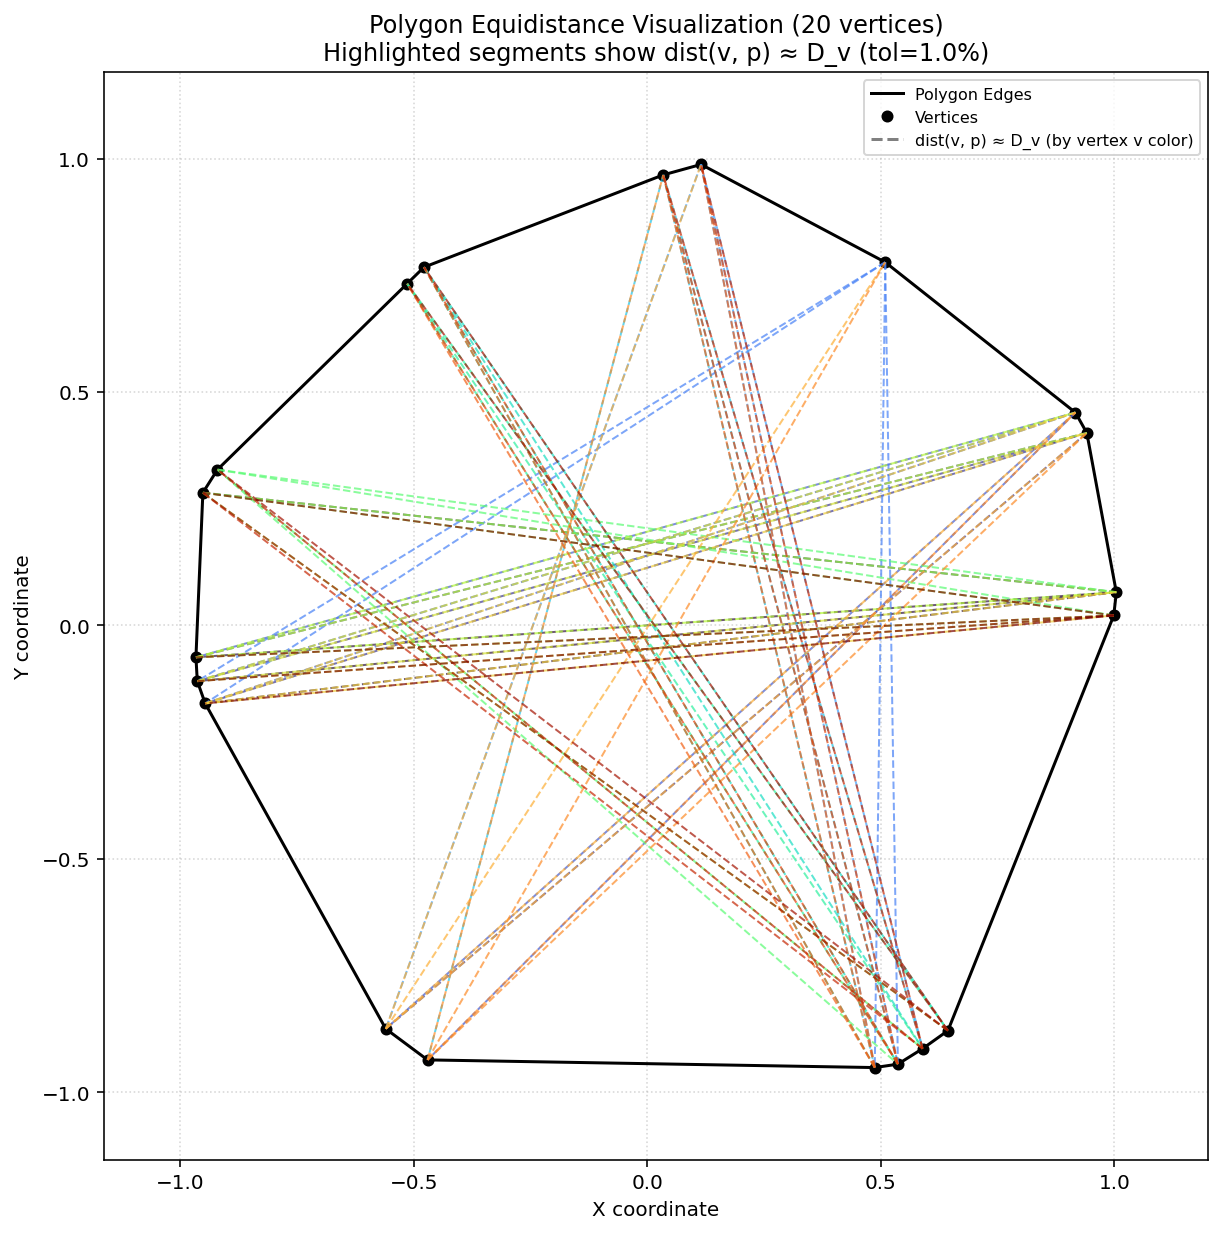

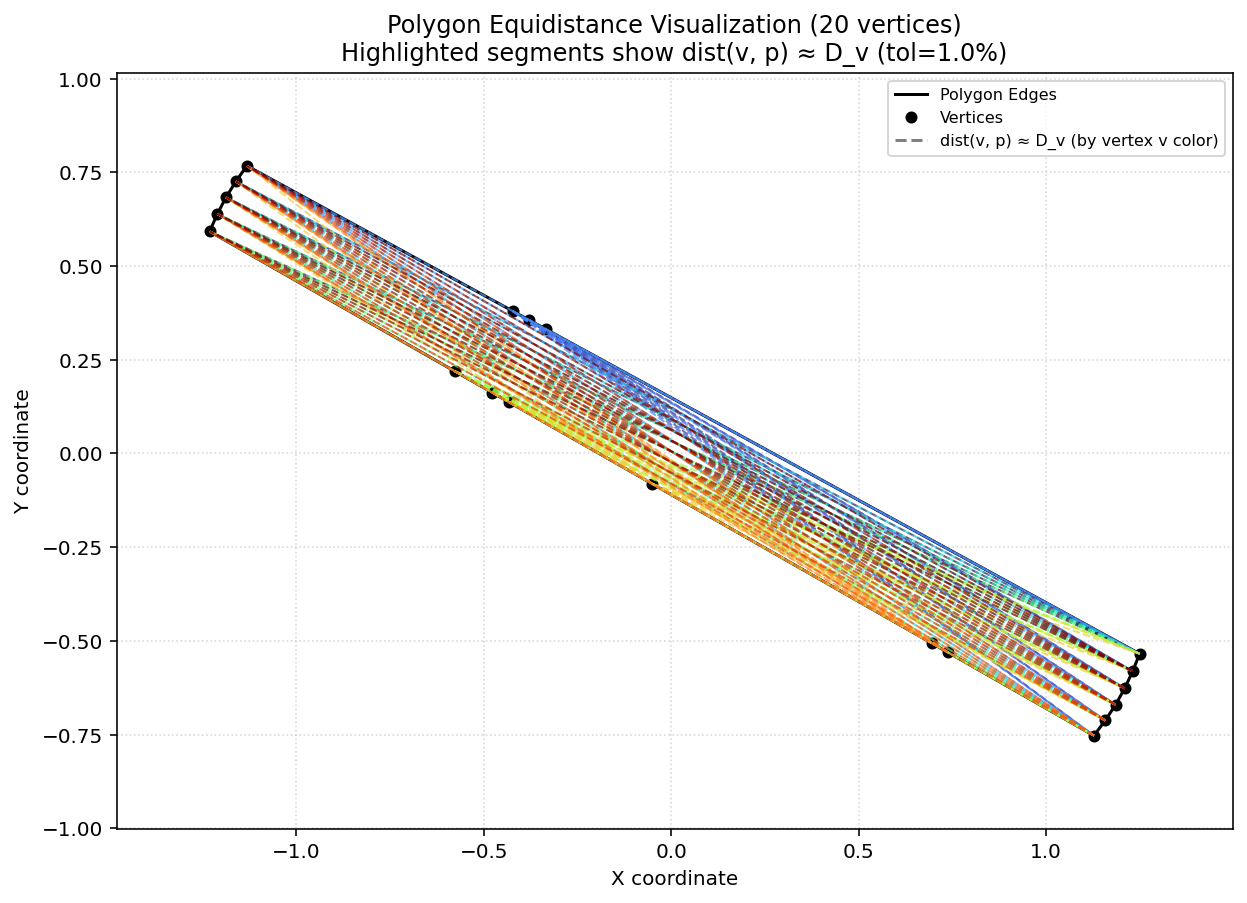

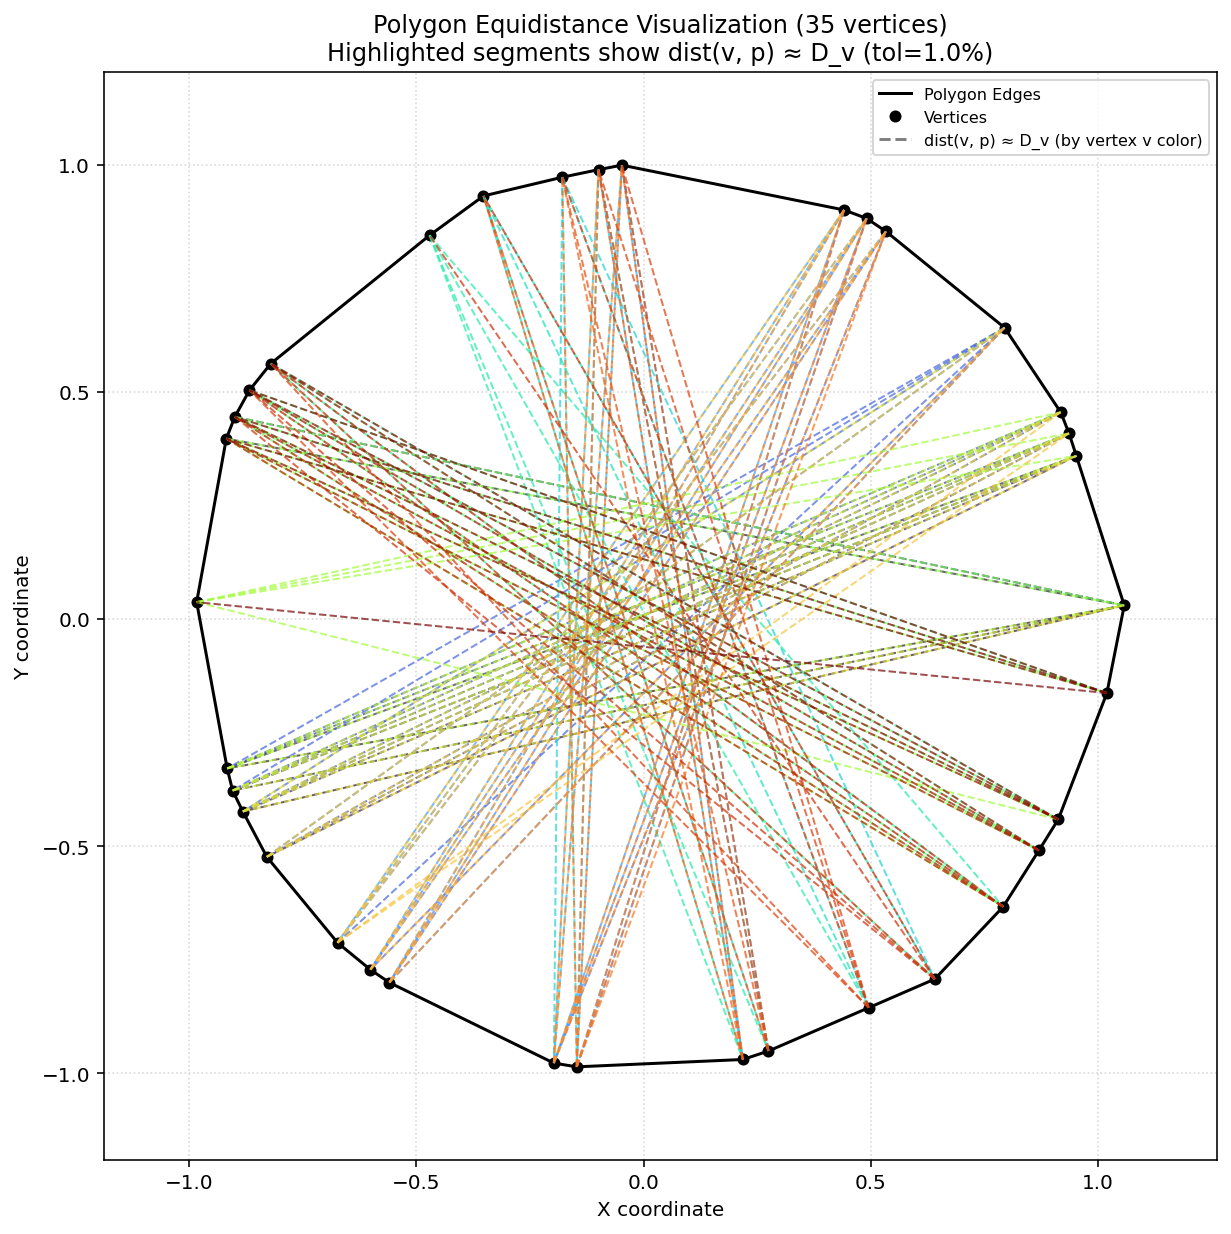

In [ ]:
#@title AlphaEvolve's constructions typically cluster points close together, to get good approximate constructions. This is not what we want!
import numpy as np

myarr1 = [(np.float64(1.004134169137097), np.float64(0.07126649484939185)), (np.float64(0.9409928266607784), np.float64(0.4123396232784121)), (np.float64(0.9165424370496866), np.float64(0.4559688560988074)), (np.float64(0.5093125517716908), np.float64(0.7778965403516866)), (np.float64(0.1149026091320098), np.float64(0.9873043562130449)), (np.float64(0.03390638399580979), np.float64(0.9649032600399472)), (np.float64(-0.4784590594404921), np.float64(0.7672811357706218)), (np.float64(-0.5144963643331999), np.float64(0.7320417075954149)), (np.float64(-0.9207752382963972), np.float64(0.33372664408476277)), (np.float64(-0.9519944500778895), np.float64(0.2843722284080491)), (np.float64(-0.9668455615180241), np.float64(-0.06817517623939161)), (np.float64(-0.9639265695289325), np.float64(-0.11924248714072332)), (np.float64(-0.9470176316469494), np.float64(-0.16693208831528877)), (np.float64(-0.5603278672132956), np.float64(-0.8637761886489661)), (np.float64(-0.47085279820387316), np.float64(-0.9303306176963547)), (np.float64(0.48690020080867835), np.float64(-0.9467449344243558)), (np.float64(0.5364428927402161), np.float64(-0.9394331113859005)), (np.float64(0.5893124549790547), np.float64(-0.9062770648981374)), (np.float64(0.6435454414832619), np.float64(-0.8676310266341241)), (np.float64(0.9987035725007702), np.float64(0.021441848693105867))]
myarr2 = [(np.float64(1.2497221832592478), np.float64(-0.534324890712548)), (np.float64(-0.33433479409989514), np.float64(0.3315670570563435)), (np.float64(-0.3782078922745673), np.float64(0.3555493777008542)), (np.float64(-0.4223403192832722), np.float64(0.3796734550714596)), (np.float64(-1.1317990898770884), np.float64(0.7674844004656376)), (np.float64(-1.1613654348920406), np.float64(0.725957070252956)), (np.float64(-1.1876538111969963), np.float64(0.6833473357529398)), (np.float64(-1.210822561288201), np.float64(0.6390392211551309)), (np.float64(-1.2312937308851966), np.float64(0.5923480830397957)), (np.float64(-0.5769761661299708), np.float64(0.21931869002041066)), (np.float64(-0.4768609874173963), np.float64(0.1622425753735107)), (np.float64(-0.4334240765161207), np.float64(0.13747899669537042)), (np.float64(-0.049924062472224404), np.float64(-0.08115608930041183)), (np.float64(0.6948834456175214), np.float64(-0.5057742056183557)), (np.float64(0.7383203560604911), np.float64(-0.5305377839394385)), (np.float64(1.1277886521837863), np.float64(-0.7525754139883994)), (np.float64(1.1579649653546213), np.float64(-0.7121161513405342)), (np.float64(1.1854134507771446), np.float64(-0.6701989712129289)), (np.float64(1.2098456902384314), np.float64(-0.6265748302389446)), (np.float64(1.2310641828417268), np.float64(-0.5807479262328467))]
myarr3 = [(np.float64(1.058184612265878), np.float64(0.03021051199029378)), (np.float64(0.9526802216434538), np.float64(0.35931392993425443)), (np.float64(0.936630502841594), np.float64(0.40888192699633163)), (np.float64(0.9182339011934214), np.float64(0.45539190241091015)), (np.float64(0.7947099949944879), np.float64(0.6414175628447322)), (np.float64(0.5334373044430464), np.float64(0.8534306151488393)), (np.float64(0.49115726258065046), np.float64(0.8820011729644099)), (np.float64(0.44141324073102955), np.float64(0.900600847404316)), (np.float64(-0.047699957570690066), np.float64(0.9992620142349723)), (np.float64(-0.09914145421293241), np.float64(0.9893775100047097)), (np.float64(-0.1788080274311069), np.float64(0.9727104690820086)), (np.float64(-0.3523624814035755), np.float64(0.9314879092296605)), (np.float64(-0.47101994985483603), np.float64(0.844785064996846)), (np.float64(-0.8207394476357982), np.float64(0.5623143655644092)), (np.float64(-0.8674874743153319), np.float64(0.503771923065736)), (np.float64(-0.8997322526555248), np.float64(0.4452719903107675)), (np.float64(-0.9185144672125943), np.float64(0.3972311449197546)), (np.float64(-0.9837694050161754), np.float64(0.037305573404610444)), (np.float64(-0.9165679163312301), np.float64(-0.32877328029425074)), (np.float64(-0.9046537734663688), np.float64(-0.37737292658544414)), (np.float64(-0.8820734427806419), np.float64(-0.423618305722261)), (np.float64(-0.8293860064283141), np.float64(-0.5233509721631966)), (np.float64(-0.6737329961336798), np.float64(-0.712306539921484)), (np.float64(-0.6013661903864096), np.float64(-0.771654789103778)), (np.float64(-0.5594994956291376), np.float64(-0.8000929537346212)), (np.float64(-0.19747444057267383), np.float64(-0.9774148840290136)), (np.float64(-0.14702325599882238), np.float64(-0.9856343346796786)), (np.float64(0.2185900464014084), np.float64(-0.9694700506315223)), (np.float64(0.2749757705401603), np.float64(-0.9507812039181744)), (np.float64(0.4953956608049427), np.float64(-0.855564602801567)), (np.float64(0.6409676687152505), np.float64(-0.7924292034945185)), (np.float64(0.7916138271074313), np.float64(-0.633227733206984)), (np.float64(0.870286866695528), np.float64(-0.5092352511991306)), (np.float64(0.9128514721909142), np.float64(-0.4410101860823193)), (np.float64(1.0199240818866453), np.float64(-0.16282921693961513))]

plot_polygon_equidistance(myarr1)
plot_polygon_equidistance(myarr2)
plot_polygon_equidistance(myarr3)


## A better scoring function

In the previous program, we forced all points to be at distance at least 0.05 apart, after normalizing the polygon to have average distance 1. This was a naive way of doing things.

If the score is "worst equidistance error" / ( (min side length)^2 / diameter ) then no further upper or lower bounds on distances are needed, as naive attempts to cheat by moving some points to be really close or really far apart stop working.

In [ ]:
#@title New evaluation code

def calculate_vertex_error(
    vertex_index: int, polygon_points: List[Tuple[float, float]]
) -> float:
    """Calculates the minimum equidistance error for 4 points relative to a vertex.

    Error is defined as the range (max - min) of the best 4 equidistant points.
    """
    num_vertex = len(polygon_points)
    # We need at least 1 vertex + 4 others = 5 points total
    if num_vertex < 5:
        return float('inf')

    v = np.array(polygon_points[vertex_index])
    distances = []
    for i, p_tuple in enumerate(polygon_points):
        if i == vertex_index:
            continue
        # Calculate Euclidean distance
        distances.append(np.linalg.norm(v - np.array(p_tuple)))

    distances.sort()

    # We want the best cluster of 4 distances.
    # In a sorted list, the best 4 will always be consecutive.
    # We find the 4 consecutive distances with the smallest range (dist[i+3] - dist[i]).
    min_range = float('inf')
    # Iterate through all possible clusters of 4
    for i in range(len(distances) - 3):
        current_range = distances[i+3] - distances[i]
        if current_range < min_range:
            min_range = current_range

    return min_range

def calculate_polygon_score_new(
    polygon_points: List[Tuple[float, float]], num_vertex: int
) -> float:
    """Calculates the normalized error score for the polygon.

    Formula: Worst_Vertex_Error / (Min_Side_Length^2 / Diameter)
    Target: MINIMIZE this score (ideally towards 0).
    """
    # --- Basic Validation ---
    if len(polygon_points) != num_vertex or num_vertex < 5:
        return 1e9  # Return high error for invalid inputs

    points_np = np.array(polygon_points)

    # --- 1. Calculate Geometric Properties ---
    # Diameter: Maximum distance between any pair of points
    # (Using brute force O(N^2), sufficient for small N like 5-10)
    max_dist_sq = 0.0
    for i in range(num_vertex):
        for j in range(i + 1, num_vertex):
            dist_sq = np.sum((points_np[i] - points_np[j])**2)
            if dist_sq > max_dist_sq:
                max_dist_sq = dist_sq
    diameter = np.sqrt(max_dist_sq)

    # Min Side Length: Minimum distance between adjacent vertices
    # Assumes polygon_points are ordered around the perimeter.
    min_side_sq = float('inf')
    for i in range(num_vertex):
        p1 = points_np[i]
        p2 = points_np[(i + 1) % num_vertex] # Wrap around to first point
        side_sq = np.sum((p1 - p2)**2)
        if side_sq < min_side_sq:
            min_side_sq = side_sq
    min_side = np.sqrt(min_side_sq)

    # Avoid division by zero if points overlap significantly
    if min_side < 1e-9 or diameter < 1e-9:
        return -1e9 # Penalize degenerate polygons

    # Calculate the normalization factor: (min_side^2) / diameter
    denominator = (min_side ** 2) / diameter

    # --- 2. Calculate Worst Equidistance Error ---
    # Find the maximum error across all vertices
    max_vertex_error = 0.0
    for i in range(num_vertex):
        error = calculate_vertex_error(i, polygon_points)
        if error > max_vertex_error:
            max_vertex_error = error

    # --- 3. Final Score Calculation ---
    final_score = max_vertex_error / denominator

    # Now a score of 0 means a perfect solution
    return -final_score

/tmp/ipython-input-2-1517633699.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('turbo', num_vertex) # 'tab10', 'tab20', 'viridis', 'turbo' are good options


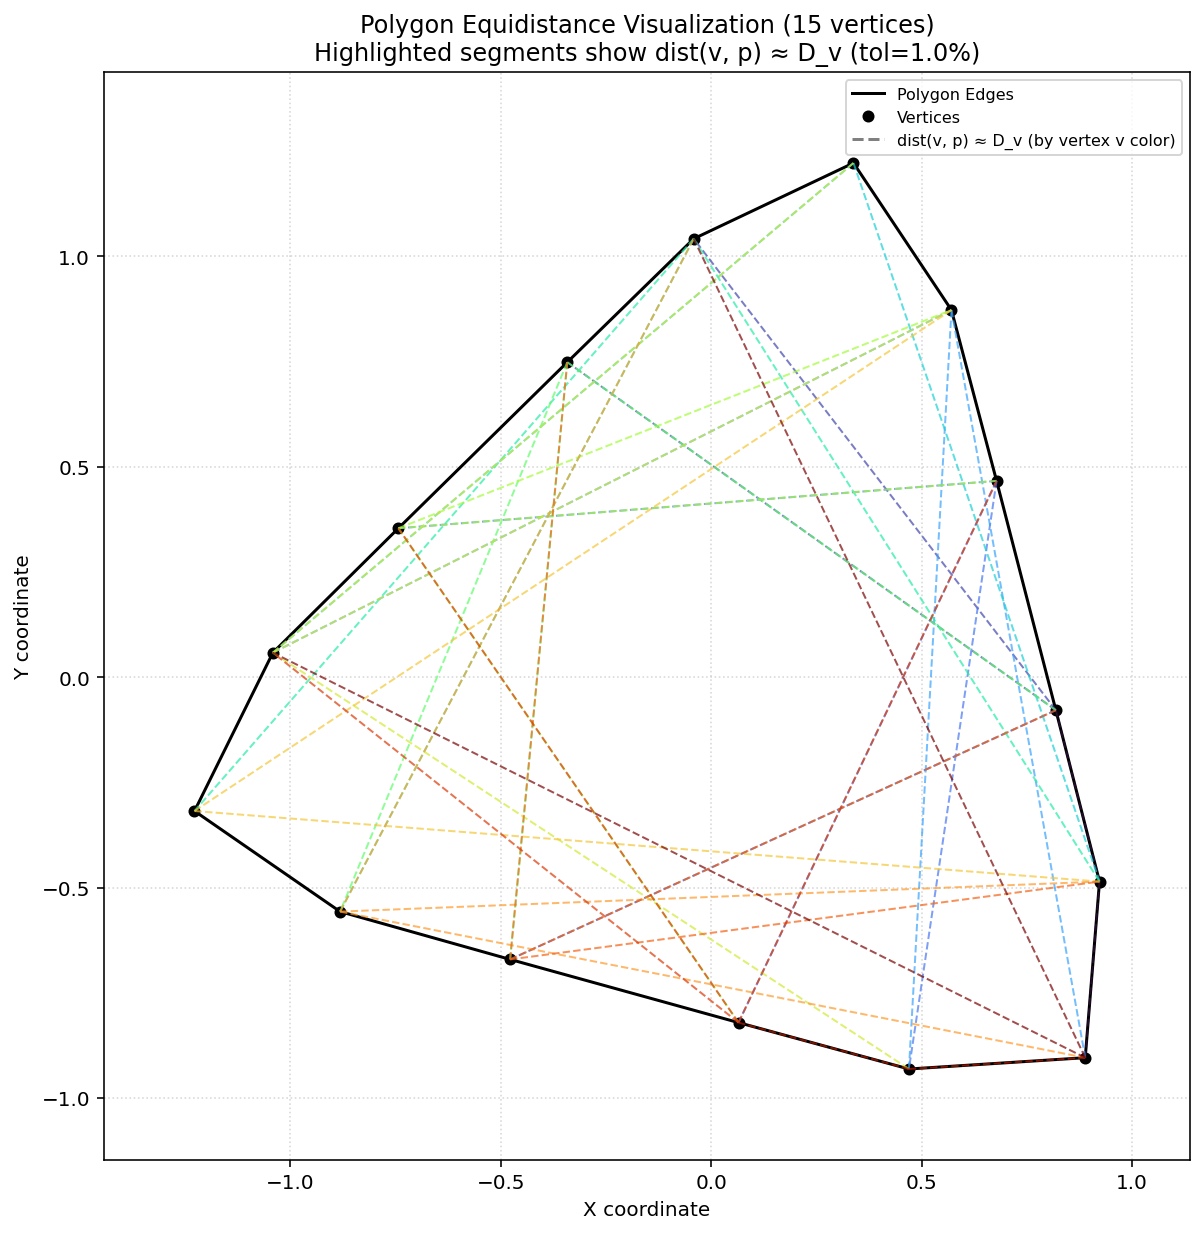

score: -0.48898477500990667


In [ ]:
#@title AlphaEvolve didn't find a solution for any n we tried

#Example construction found by AlphaEvolve
myarr4     = [(np.float64(0.9229580674756486), np.float64(-0.4855261796173603)), (np.float64(0.8192371898636124), np.float64(-0.07826821032617266)), (np.float64(0.6783742458339437), np.float64(0.46665981257104183)), (np.float64(0.5711418811305328), np.float64(0.8726439928232128)), (np.float64(0.33833746035494533), np.float64(1.2220174184565895)), (np.float64(-0.04131090577439885), np.float64(1.042006158079815)), (np.float64(-0.3417762245842307), np.float64(0.7486557900309958)), (np.float64(-0.7431246689818207), np.float64(0.3540554829028856)), (np.float64(-1.0413324490428146), np.float64(0.058391976313665994)), (np.float64(-1.2275757011419848), np.float64(-0.31784511067698806)), (np.float64(-0.8816243638252462), np.float64(-0.5568373089371434)), (np.float64(-0.47757130220639626), np.float64(-0.6704877826221148)), (np.float64(0.0651308255733137), np.float64(-0.8206152763337967)), (np.float64(0.4701143100190053), np.float64(-0.9308638333069843)), (np.float64(0.8890216353058906), np.float64(-0.9039869293576459))]

plot_polygon_equidistance(myarr4)

print(f"score: {calculate_polygon_score_new(myarr4, len(myarr4))}")

/tmp/ipython-input-2-1517633699.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('turbo', num_vertex) # 'tab10', 'tab20', 'viridis', 'turbo' are good options


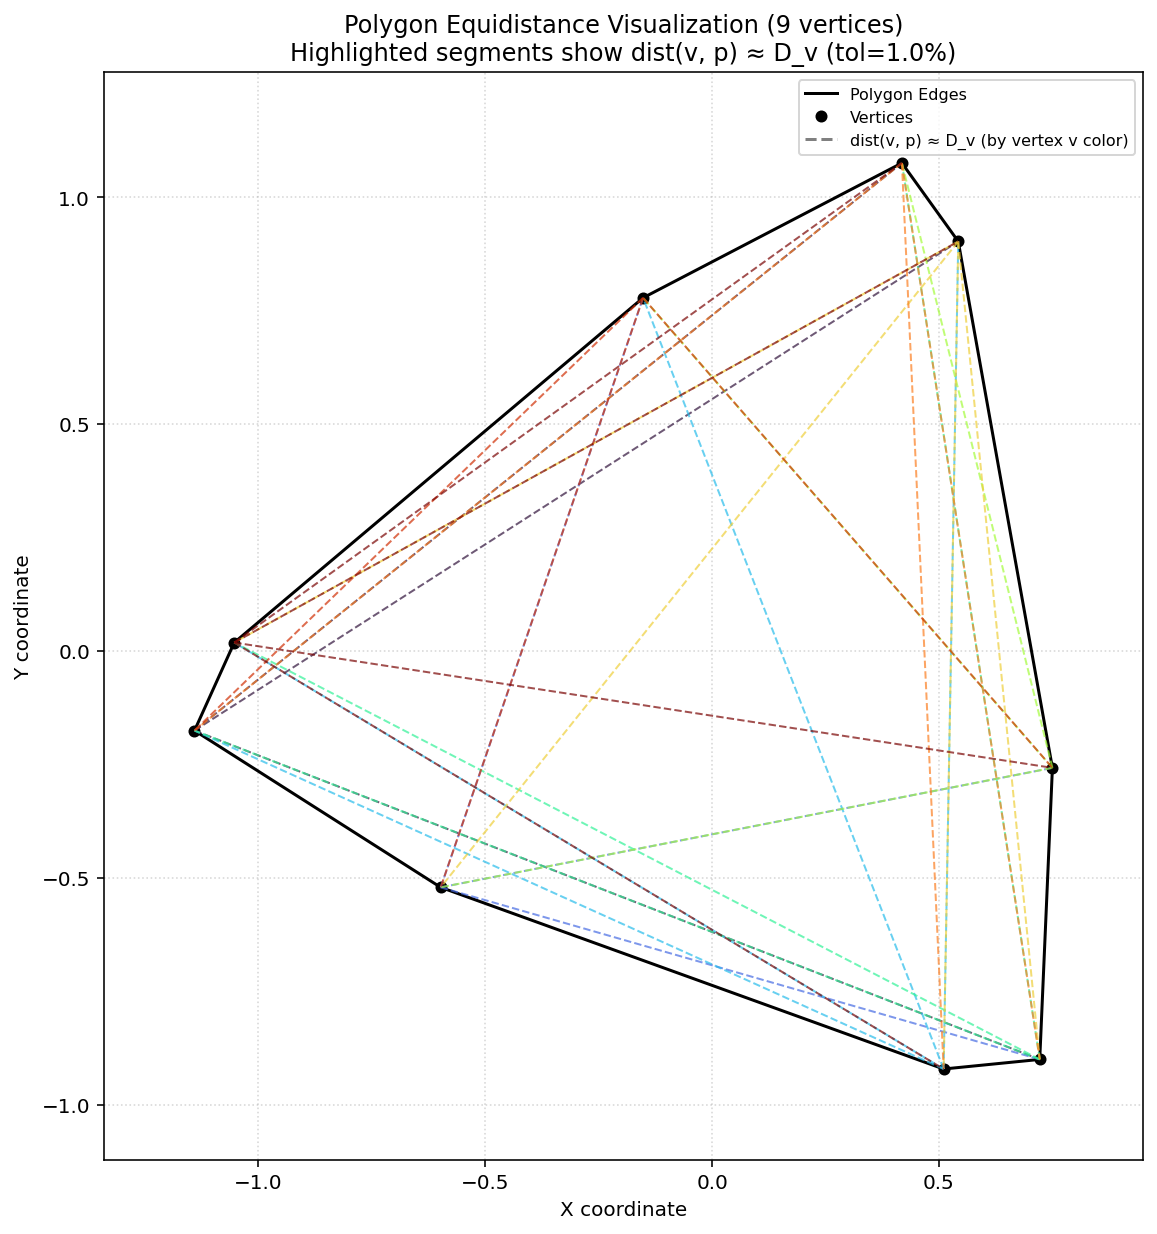

score: -1.9593383714453804e-14


In [ ]:
#@title For 3 equidistant, AlphaEvolve easily finds a solution


def calculate_vertex_error(
    vertex_index: int, polygon_points: List[Tuple[float, float]]
) -> float:
    """Calculates the minimum equidistance error for 4 points relative to a vertex.

    Error is defined as the range (max - min) of the best 4 equidistant points.
    """
    num_vertex = len(polygon_points)
    # We need at least 1 vertex + 4 others = 5 points total
    if num_vertex < 5:
        return float('inf')

    v = np.array(polygon_points[vertex_index])
    distances = []
    for i, p_tuple in enumerate(polygon_points):
        if i == vertex_index:
            continue
        # Calculate Euclidean distance
        distances.append(np.linalg.norm(v - np.array(p_tuple)))

    distances.sort()

    # We want the best cluster of 4 distances.
    # In a sorted list, the best 4 will always be consecutive.
    # We find the 4 consecutive distances with the smallest range (dist[i+3] - dist[i]).
    min_range = float('inf')
    # Iterate through all possible clusters of 3
    for i in range(len(distances) - 2):
        current_range = distances[i+2] - distances[i]
        if current_range < min_range:
            min_range = current_range

    return min_range

points = [(np.float64(-1.1405215639392907), np.float64(-0.1753692817852727)), (np.float64(-0.5980127669757851), np.float64(-0.5208140189539018)), (np.float64(0.51034525825014), np.float64(-0.9211354847374897)), (np.float64(0.7221350350391229), np.float64(-0.9000360070427476)), (np.float64(0.750044554549042), np.float64(-0.2574872385115025)), (np.float64(0.5425541009848887), np.float64(0.9025397007142961)), (np.float64(0.4183865289001676), np.float64(1.0754052888280201)), (np.float64(-0.15203178757325655), np.float64(0.7783012574654046)), (np.float64(-1.0528993592350289), np.float64(0.01859578402319345))]
plot_polygon_equidistance(points)

print(f"score: {calculate_polygon_score_new(points, len(points))}")

In [ ]:
#@title Program found by AlphaEvolve (for 3 equidistant case)

def _recenter_and_normalize(polygon_points: List[Tuple[float, float]], target_avg_radius: float = 10.0) -> List[Tuple[float, float]]:
  """
  Recalculates the polygon points to be centered at (0,0) and have a target average radius.
  This helps stabilize the search by providing a consistent reference frame.
  This function does NOT sort the points; sorting for convexity/order must be handled elsewhere.
  """
  if not polygon_points:
    return []

  num_v = len(polygon_points)
  center_x = sum(p[0] for p in polygon_points) / num_v
  center_y = sum(p[1] for p in polygon_points) / num_v

  recenter_points = [(p[0] - center_x, p[1] - center_y) for p in polygon_points]

  current_avg_radius = sum(math.sqrt(p[0]**2 + p[1]**2) for p in recenter_points) / num_v

  # Avoid division by zero if all points are at the center or very close (degenerate polygon)
  if current_avg_radius < 1e-6:
    return recenter_points # Return as is, they are effectively (0,0)

  scale_factor = target_avg_radius / current_avg_radius
  normalized_points = [(p[0] * scale_factor, p[1] * scale_factor) for p in recenter_points]

  return normalized_points

def search_for_best_polygon(num_vertex: int) -> List[Tuple[float, float]]:
  """Searches for the best convex polygon maximizing the minimum vertex score."""

  MAX_TIME_SECONDS = 50.0  # Allow some buffer for evaluation harness (target is ~55s)
  RADIUS = 10.0 # Target average radius for polygon normalization

  use_c3_symmetry = (num_vertex == 9)
  num_generators = 3 if use_c3_symmetry else num_vertex

  # Objective function for differential_evolution (minimize -score) using polar coordinates
  def _objective_function(flat_params: np.ndarray, num_vertex: int, base_radius: float) -> float:
    # Step 1: Convert flat_params to "generator" points.
    generator_points = []
    for i in range(num_generators):
      dr = flat_params[2 * i]
      dtheta = flat_params[2 * i + 1]

      r = base_radius + dr
      # Ensure radii are positive. If dr pushes it too low, clamp it.
      if r < 0.1: r = 0.1

      base_angle = 2 * np.pi * i / num_vertex
      theta = base_angle + dtheta

      generator_points.append((r * math.cos(theta), r * math.sin(theta)))

    # Step 2: If using symmetry, expand generator points to the full polygon.
    if use_c3_symmetry:
      points_cartesian_raw = []
      rot_angle_120 = 2 * np.pi / 3
      rot_angle_240 = 4 * np.pi / 3
      cos1, sin1 = math.cos(rot_angle_120), math.sin(rot_angle_120)
      cos2, sin2 = math.cos(rot_angle_240), math.sin(rot_angle_240)
      for x, y in generator_points:
        points_cartesian_raw.append((x, y))
        points_cartesian_raw.append((x * cos1 - y * sin1, x * sin1 + y * cos1))
        # Corrected a bug from the prior good program (y-coordinate for 240-degree rotation was using sin1/cos1)
        points_cartesian_raw.append((x * cos2 - y * sin2, x * sin2 + y * cos2))
    else:
      points_cartesian_raw = generator_points

    # Step 3: Recenter and normalize points.
    normalized_points = _recenter_and_normalize(points_cartesian_raw, base_radius)

    # Sort points by angle relative to the origin to ensure consistent order for convexity check.
    # This is crucial as dtheta perturbations can change relative order of points, and
    # `_recenter_and_normalize` does not inherently sort them.
    sorted_normalized_points = sorted(normalized_points, key=lambda p: math.atan2(p[1], p[0]))

    polygon_points = sorted_normalized_points # Use the pre-computed and sorted points
    score = calculate_polygon_score(polygon_points, num_vertex)
    return -score

  def _create_polygon_from_params(flat_params: np.ndarray, num_vertex: int, base_radius: float, use_c3_symmetry: bool) -> List[Tuple[float, float]]:
    num_generators = 3 if use_c3_symmetry else num_vertex

    generator_points = []
    for i in range(num_generators):
      dr = flat_params[2 * i]
      dtheta = flat_params[2 * i + 1]

      r = base_radius + dr
      if r < 0.1: r = 0.1

      base_angle = 2 * np.pi * i / num_vertex
      theta = base_angle + dtheta

      generator_points.append((r * math.cos(theta), r * math.sin(theta)))

    if use_c3_symmetry:
      points_cartesian_raw = []
      rot_angle_120 = 2 * np.pi / 3
      rot_angle_240 = 4 * np.pi / 3
      cos1, sin1 = math.cos(rot_angle_120), math.sin(rot_angle_120)
      cos2, sin2 = math.cos(rot_angle_240), math.sin(rot_angle_240)
      for x, y in generator_points:
        points_cartesian_raw.append((x, y))
        points_cartesian_raw.append((x * cos1 - y * sin1, x * sin1 + y * cos1))
        points_cartesian_raw.append((x * cos2 - y * sin2, x * sin2 + y * cos2))
    else:
      points_cartesian_raw = generator_points

    normalized_points = _recenter_and_normalize(points_cartesian_raw, base_radius)
    sorted_normalized_points = sorted(normalized_points, key=lambda p: math.atan2(p[1], p[0]))

    return sorted_normalized_points

  # Define bounds for differential evolution in polar coordinates (dr, dtheta)
  dr_bounds = (-0.5 * RADIUS, 0.5 * RADIUS)
  # dtheta bounds: allows for angular deviation. With explicit sorting in the objective,
  # the range can be wider to allow more exploration, as order swaps are now handled.
  # A range up to +/- pi/num_vertex allows a point to move halfway to its neighbors without
  # being truly "out of order" in the geometric sense before sorting.
  dtheta_bounds = (-np.pi / num_vertex, np.pi / num_vertex)

  bounds = []
  for _ in range(num_generators):
    bounds.append(dr_bounds)
    bounds.append(dtheta_bounds)

  start_time = time.time()

  # Callback to stop optimization based on time limit
  def _de_callback(xk, convergence=None):
    if time.time() - start_time > MAX_TIME_SECONDS:
      raise StopIteration("Time limit exceeded.")

  print(f'Starting Differential Evolution (polar coords) for {num_vertex} vertices...')

  # Choose popsize (number of individuals in each generation).
  # Let's make popsize adaptive: (D * 3.5) where D is number of variables.
  de_popsize = max(40, min(80, int(2 * num_generators * 3.5)))

  # Generate initial population in polar coordinate parameters (dr, dtheta)
  initial_population_list = []
  for _ in range(de_popsize):
      initial_params_for_individual = []
      for i in range(num_generators):
          # Initial radial perturbation, sampling from the full dr_bounds for maximum diversity.
          dr_init = np.random.uniform(dr_bounds[0], dr_bounds[1])
          # Initial angular perturbation, sampling from the full dtheta_bounds for maximum diversity.
          dtheta_init = np.random.uniform(dtheta_bounds[0], dtheta_bounds[1])
          initial_params_for_individual.extend([dr_init, dtheta_init])
      initial_population_list.append(initial_params_for_individual)

  initial_population_array = np.array(initial_population_list)

  try:
    result = optimize.differential_evolution(
        _objective_function,
        bounds,
        args=(num_vertex, RADIUS), # Pass RADIUS to the objective function
        maxiter=2000, # Increased maxiter, time callback is the primary limit
        popsize=de_popsize,
        tol=0.0001,
        disp=False,
        polish=True,
        callback=_de_callback,
        init=initial_population_array,
        strategy='currenttobest1bin', # Use a hybrid strategy for better balance of exploration and exploitation
        # Parameters for enhanced search:
        mutation=0.8,       # Standard mutation factor, 'currenttobest' provides exploitation
        recombination=0.85, # Increased crossover probability to promote faster mixing of promising solutions
    )
  except StopIteration as e:
    print(f"Differential Evolution stopped: {e}")

  # Convert best 1D array of polar parameters back to polygon points using the helper.
  best_polar_params = result.x
  best_polygon_points = _create_polygon_from_params(best_polar_params, num_vertex, RADIUS, use_c3_symmetry)

  # Calculate the final score for the properly processed best polygon.
  # This score should match -result.fun closely if not for float precision.
  best_score = calculate_polygon_score(best_polygon_points, num_vertex)
  print(f'Final score for {num_vertex} vertices: {best_score:.6f}')
  return best_polygon_points
